In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torchinfo import summary
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers.modeling_outputs import ImageClassifierOutput
from typing import List, Tuple, Dict, Optional

In [2]:
BATCH_SIZE = 512
LR = 1e-3
NUM_EPOCHS = 25
IMG_SIZE = 28
HIDDEN_DIM = 128
INTERMEDIATE_DIM = 256
NUM_BLOCKS = 1
NUM_CLASSES = 10
PATIENCE = 3
LOGGING_STEPS = 100
ATTENTION_HEAD_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
%%capture
train_dataset = datasets.MNIST('../data/MNIST/', download=True, train=True)
test_dataset = datasets.MNIST('../data/MNIST/', download=True, train=False)

Image shape: (28, 28), Label: 5


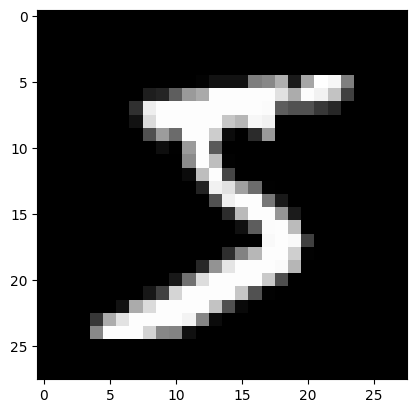

In [4]:
print(f'Image shape: {np.array(train_dataset[0][0]).shape}, Label: {np.array(train_dataset[0][1])}')
plt.imshow(np.array(train_dataset[0][0]).squeeze(), cmap='gray')
plt.show()

In [5]:
# calcluate mean and std of the dataset
mean = train_dataset.data.float().mean() / 255
std = train_dataset.data.float().std() / 255
print(f'Mean: {mean}, Std: {std}')

Mean: 0.13066047430038452, Std: 0.30810779333114624


In [6]:
%%capture
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)
train_dataset = datasets.MNIST('../data/MNIST/', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('../data/MNIST/', download=True, train=False, transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for ex in test_loader:
    print(ex[0].shape, ex[1].shape)
    break

torch.Size([512, 1, 28, 28]) torch.Size([512])


In [8]:
class DataCollator:
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]) -> Dict[str, torch.Tensor]:
        return {
            'x': torch.stack([f[0] for f in batch]),
            'labels': torch.tensor([f[1] for f in batch])
        }

In [9]:
class Attention(nn.Module):
    def __init__(self, hidden_dim: torch.Tensor):
        super().__init__()
        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)
        self.sqrt_d = math.sqrt(hidden_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: # (B, L, d)
        Q = self.W_Q(x) # (B, L, d)
        K = self.W_K(x) # (B, L, d)
        V = self.W_V(x) # (B, L, d)
        a = Q.matmul(K.permute(0, 2, 1)) / self.sqrt_d # (B, 50, 50)
        a = a.softmax(dim=-1).matmul(V)
        return a


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim: torch.Tensor):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = ATTENTION_HEAD_SIZE
        self.head_dim = hidden_dim // ATTENTION_HEAD_SIZE
        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)
        self.sqrt_d = math.sqrt(hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # (batch_size, length, hidden_dim)
        batch_size = x.size(0)  
        Q = self.W_Q(x).reshape(batch_size, -1, self.num_heads, self.head_dim) # (batch_size, length, num_heads, head_dim)
        K = self.W_K(x).reshape(batch_size, -1, self.num_heads, self.head_dim) # (batch_size, length, num_heads, head_dim)
        V = self.W_V(x).reshape(batch_size, -1, self.num_heads, self.head_dim) # (batch_size, length, num_heads, head_dim)
        Q = Q.transpose(1, 2) # (batch_size, num_heads, length, head_dim)
        K = K.transpose(1, 2) # (batch_size, num_heads, length, head_dim)
        V = V.transpose(1, 2) # (batch_size, num_heads, length, head_dim)
        K = K.transpose(2, 3) # (batch_size, num_heads, head_dim, length)
        a = Q.matmul(K) / self.sqrt_d # (batch_size, num_heads, length, length)
        a = a.softmax(dim=-1) # (batch_size, num_heads, length, length)
        a = a.matmul(V) # (batch_size, num_heads, length, head_dim)
        a = a.transpose(1, 2) # (batch_size, length, num_heads, head_dim)
        a = a.reshape(batch_size, -1, self.hidden_dim) # (batch_size, length, hidden_dim)
        return a
        

class MLP(nn.Module):
    def __init__(self, hidden_dim: torch.Tensor, intermediate_dim: torch.Tensor):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, intermediate_dim)
        self.w2 = nn.Linear(intermediate_dim, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor: # (B, L, d)
        return self.w2(F.relu(self.w1(x))) # (B, L, d)


class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim: torch.Tensor, intermediate_dim: torch.Tensor, multi_head_attention: Optional[bool] = False):
        super().__init__()
        self.attention = Attention(hidden_dim) if not multi_head_attention else MultiHeadAttention(hidden_dim)
        self.mlp = MLP(hidden_dim, intermediate_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        attention_output = self.attention(x)
        attention_output = attention_output + residual
        residual = attention_output
        mlp_output = self.mlp(attention_output)
        mlp_output = mlp_output + residual
        return mlp_output


class Classifier(nn.Module):
    def __init__(self, hidden_dim: torch.Tensor, num_classes: torch.Tensor):
        super().__init__()
        self.dense = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.out(F.relu(self.dense(x)))


class SimpleNN(nn.Module):
    def __init__(self, input_size: torch.Tensor, hidden_size: torch.Tensor, num_classes: torch.Tensor):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor, labels: Optional[torch.Tensor] = None) -> ImageClassifierOutput:
        # (batch_size, 1, 28, 28), (batch_size,)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return ImageClassifierOutput(
            loss=loss,
            logits=logits
        )


class CNN(nn.Module):
    def __init__(self, num_classes: torch.Tensor):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x: torch.Tensor, labels: Optional[torch.Tensor] = None) -> ImageClassifierOutput:
        # (batch_size, 1, 28, 28), (batch_size,)
        batch_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(batch_size, -1)
        logits = self.fc(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return ImageClassifierOutput(
            loss=loss,
            logits=logits
        )


class ViT(nn.Module):
    def __init__(
        self,
        input_dim: torch.Tensor,
        hidden_dim: torch.Tensor,
        intermediate_dim: torch.Tensor,
        num_classes: torch.Tensor,
        num_blocks: torch.Tensor,
        multi_head_attention: Optional[bool] = False
    ):
        super(ViT, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([TransformerBlock(hidden_dim, intermediate_dim, multi_head_attention) for _ in range(num_blocks)])
        self.classifier = Classifier(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, labels: Optional[torch.Tensor] = None) -> ImageClassifierOutput:
        # (batch_size, 1, 28, 28), (batch_size,)
        batch_size = x.size(0)
        img_size = x.size(-1)
        x = x.view(batch_size, img_size, img_size) # (batch_size, 784)
        x = self.embedding(x) # (batch_size, hidden_dim)
        for block in self.blocks:
            x = block(x)
        h = x.mean(dim=1)
        logits = self.classifier(h)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return ImageClassifierOutput(
            loss=loss,
            logits=logits
        )

In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    logging_dir='./logs',
    logging_steps=LOGGING_STEPS,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    load_best_model_at_end=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = (predictions == labels).mean()
    return {'accuracy': accuracy}


models = {
    'Simple Neural Network': SimpleNN(input_size=IMG_SIZE*IMG_SIZE, hidden_size=HIDDEN_DIM, num_classes=NUM_CLASSES),
    'Convolutional Neural Network': CNN(num_classes=NUM_CLASSES),
    'Vision Transformer': ViT(input_dim=IMG_SIZE, hidden_dim=HIDDEN_DIM, intermediate_dim=INTERMEDIATE_DIM, num_classes=NUM_CLASSES, num_blocks=NUM_BLOCKS),
    'Vision Transformer with Multi-Head Attention': ViT(input_dim=IMG_SIZE, hidden_dim=HIDDEN_DIM, intermediate_dim=INTERMEDIATE_DIM, num_classes=NUM_CLASSES, num_blocks=NUM_BLOCKS, multi_head_attention=True),
}

results = {}
for model_name, model in models.items():
    print(summary(model))
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollator(),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
    )
    metrics = trainer.evaluate()
    print(metrics)
    trainer.train()
    metrics = trainer.evaluate()
    print(metrics)
    trainer.accelerator.free_memory()
    torch.cuda.empty_cache()

    final_accuracy = metrics['eval_accuracy']
    results[model_name] = final_accuracy


# sort results by accuracy
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
print(results)

Layer (type:depth-idx)                   Param #
SimpleNN                                 --
├─Linear: 1-1                            100,480
├─Linear: 1-2                            1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0


{'eval_loss': 2.3067984580993652, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.1423, 'eval_runtime': 0.6427, 'eval_samples_per_second': 15558.748, 'eval_steps_per_second': 31.117}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.495100,0.251798,0.000000,0.930100
2,0.233000,0.180421,0.000000,0.947800
3,0.178800,0.144043,0.000000,0.958200
4,0.143600,0.121767,0.000000,0.965000
5,0.123700,0.110134,0.000000,0.967600
6,0.091400,0.099020,0.000000,0.970500
7,0.081800,0.093103,0.000000,0.972600
8,0.074400,0.088555,0.000000,0.973700
9,0.064600,0.081931,0.000000,0.976100
10,0.061300,0.081864,0.000000,0.975200


{'eval_loss': 0.06789097189903259, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.9796, 'eval_runtime': 0.5501, 'eval_samples_per_second': 18179.96, 'eval_steps_per_second': 36.36, 'epoch': 24.0}
Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            320
├─AvgPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─AvgPool2d: 1-4                         --
├─Linear: 1-5                            31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0


{'eval_loss': 2.3123226165771484, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.0939, 'eval_runtime': 0.8079, 'eval_samples_per_second': 12377.909, 'eval_steps_per_second': 24.756}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.549900,0.196953,0.000000,0.944600
2,0.158900,0.077817,0.000000,0.976300
3,0.089900,0.055184,0.000000,0.982600
4,0.068600,0.050271,0.000000,0.983000
5,0.058300,0.042430,0.000000,0.985700
6,0.047900,0.042136,0.000000,0.986000
7,0.042500,0.038967,0.000000,0.987200
8,0.042200,0.036387,0.000000,0.987000
9,0.036400,0.033353,0.000000,0.987700
10,0.035500,0.035909,0.000000,0.988100


{'eval_loss': 0.03271351382136345, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.9885, 'eval_runtime': 0.5507, 'eval_samples_per_second': 18157.097, 'eval_steps_per_second': 36.314, 'epoch': 14.0}
Layer (type:depth-idx)                   Param #
ViT                                      --
├─Linear: 1-1                            3,712
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─Attention: 3-1               49,536
│    │    └─MLP: 3-2                     65,920
├─Classifier: 1-3                        --
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       1,290
Total params: 136,970
Trainable params: 136,970
Non-trainable params: 0


{'eval_loss': 2.3201968669891357, 'eval_model_preparation_time': 0.0078, 'eval_accuracy': 0.0613, 'eval_runtime': 0.5438, 'eval_samples_per_second': 18389.545, 'eval_steps_per_second': 36.779}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,1.481100,0.916120,0.007800,0.690800
2,0.898200,0.724722,0.007800,0.762700
3,0.742400,0.650322,0.007800,0.779700
4,0.654200,0.586446,0.007800,0.804300
5,0.597100,0.531106,0.007800,0.825400
6,0.515500,0.505278,0.007800,0.836100
7,0.489700,0.492095,0.007800,0.844200
8,0.467300,0.508036,0.007800,0.833400
9,0.443300,0.453430,0.007800,0.855700
10,0.435300,0.432445,0.007800,0.862300


{'eval_loss': 0.3502092957496643, 'eval_model_preparation_time': 0.0078, 'eval_accuracy': 0.8903, 'eval_runtime': 0.565, 'eval_samples_per_second': 17698.374, 'eval_steps_per_second': 35.397, 'epoch': 25.0}
Layer (type:depth-idx)                   Param #
ViT                                      --
├─Linear: 1-1                            3,712
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      49,536
│    │    └─MLP: 3-2                     65,920
├─Classifier: 1-3                        --
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       1,290
Total params: 136,970
Trainable params: 136,970
Non-trainable params: 0


{'eval_loss': 2.307466745376587, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.1318, 'eval_runtime': 0.9466, 'eval_samples_per_second': 10564.55, 'eval_steps_per_second': 21.129}


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,1.521700,0.794701,0.000000,0.736000
2,0.754900,0.558931,0.000000,0.817800
3,0.553500,0.457426,0.000000,0.852700
4,0.455300,0.391060,0.000000,0.872800
5,0.400400,0.361419,0.000000,0.886100
6,0.336300,0.363883,0.000000,0.879900
7,0.312700,0.337544,0.000000,0.890300
8,0.294200,0.306466,0.000000,0.901500
9,0.274400,0.305226,0.000000,0.902000
10,0.269200,0.299222,0.000000,0.904000


{'eval_loss': 0.24373950064182281, 'eval_model_preparation_time': 0.0, 'eval_accuracy': 0.9241, 'eval_runtime': 0.6686, 'eval_samples_per_second': 14957.408, 'eval_steps_per_second': 29.915, 'epoch': 25.0}
{'Convolutional Neural Network': 0.9885, 'Simple Neural Network': 0.9796, 'Vision Transformer with Multi-Head Attention': 0.9241, 'Vision Transformer': 0.8903}


In [11]:
transformer_model = trainer.model
print(transformer_model)

ViT(
  (embedding): Linear(in_features=28, out_features=128, bias=True)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_Q): Linear(in_features=128, out_features=128, bias=True)
        (W_K): Linear(in_features=128, out_features=128, bias=True)
        (W_V): Linear(in_features=128, out_features=128, bias=True)
      )
      (mlp): MLP(
        (w1): Linear(in_features=128, out_features=256, bias=True)
        (w2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Classifier(
    (dense): Linear(in_features=128, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [16]:
from transformers import PretrainedConfig, PreTrainedModel


class HFViTConfig(PretrainedConfig):
    model_type = "vit"
    def __init__(
        self,
        input_dim: int,
        hidden_size: int,
        intermediate_size: int,
        num_hidden_layers: int,
        num_classes: int,
        multi_head_attention: bool,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_classes = num_classes
        self.multi_head_attention = multi_head_attention



class HFViT(PreTrainedModel):
    config_class = HFViTConfig
    def __init__(self, config: HFViTConfig):
        super().__init__(config)
        self.embedding = nn.Linear(config.input_dim, config.hidden_size)
        self.blocks = nn.ModuleList([TransformerBlock(config.hidden_size, config.intermediate_size, config.multi_head_attention) for _ in range(config.num_hidden_layers)])
        self.classifier = Classifier(config.hidden_size, config.num_classes)

    def forward(self, x: torch.Tensor, labels: Optional[torch.Tensor] = None) -> ImageClassifierOutput:
        # (batch_size, 1, 28, 28), (batch_size,)
        batch_size = x.size(0)
        img_size = x.size(-1)
        x = x.view(batch_size, img_size, img_size) # (batch_size, 784)
        x = self.embedding(x) # (batch_size, hidden_dim)
        for block in self.blocks:
            x = block(x)
        h = x.mean(dim=1)
        logits = self.classifier(h)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return ImageClassifierOutput(
            loss=loss,
            logits=logits
        )


config = HFViTConfig(input_dim=IMG_SIZE, hidden_size=HIDDEN_DIM, intermediate_size=INTERMEDIATE_DIM, num_hidden_layers=NUM_BLOCKS, num_classes=NUM_CLASSES, multi_head_attention=True)
hf_model = HFViT(config)
summary(hf_model)

Layer (type:depth-idx)                   Param #
HFViT                                    --
├─Linear: 1-1                            3,712
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      49,536
│    │    └─MLP: 3-2                     65,920
├─Classifier: 1-3                        --
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       1,290
Total params: 136,970
Trainable params: 136,970
Non-trainable params: 0

In [17]:
hf_model.load_state_dict(transformer_model.state_dict())
summary(hf_model)

Layer (type:depth-idx)                   Param #
HFViT                                    --
├─Linear: 1-1                            3,712
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─MultiHeadAttention: 3-1      49,536
│    │    └─MLP: 3-2                     65,920
├─Classifier: 1-3                        --
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       1,290
Total params: 136,970
Trainable params: 136,970
Non-trainable params: 0

In [ ]:
hf_model.push_to_hub('lhallee/mnist-vit', private=False)

In [ ]:
hf_model.load_from_hub('lhallee/mnist-vit')